# CNNs

In this notebook you will learn how to build Convolutional Neural Networks (CNNs) for image processing.

## Imports

In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sklearn
import sys
import tensorflow as tf
from tensorflow import keras
import time

In [3]:
print("python", sys.version)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

python 3.6.8 |Anaconda, Inc.| (default, Dec 29 2018, 19:04:46) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
matplotlib 3.0.2
numpy 1.15.4
pandas 0.23.4
sklearn 0.20.1
tensorflow 2.0.0-dev20190126
tensorflow.python.keras.api._v2.keras 2.2.4-tf


In [4]:
assert sys.version_info >= (3, 5) # Python ≥3.5 required
assert tf.__version__ >= "2.0"    # TensorFlow ≥2.0 required

In [5]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [6]:
keras.backend.clear_session()

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 1 – Simple CNN

### 1.1)
Load CIFAR10 using `keras.datasets.cifar10.load_data()`, and split it into a training set (45,000 images), a validation set (5,000 images) and a test set (10,000 images). Make sure the pixel values range from 0 to 1. Visualize a few images using `plt.imshow()`.

In [ ]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

In [ ]:
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
(len(X_train), len(y_train)), (len(X_valid), len(y_valid)), (len(X_test), len(y_test))

In [ ]:
n_rows = 5
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(classes[y_train[index][0]])
plt.show()

### 1.2)
Build and train a baseline model with a few dense layers, and plot the learning curves. Use the model's `summary()` method to count the number of parameters in this model.

**Tip**:

* Recall that to plot the learning curves, you can simply create a Pandas `DataFrame` with the `history.history` dict, then call its `plot()` method.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 32, 32, 3)
X_valid_scaled = scaler.transform(X_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 32, 32, 3)
X_test_scaled = scaler.transform(X_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 32, 32, 3)

In [ ]:
model = keras.models.Sequential(layers=[
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=300, activation='relu'),
    keras.layers.Dense(units=10, activation='softmax') 
])

initial_weights = model.get_weights()

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

%time history = model.fit(X_train_scaled, y_train, epochs=100, \
                          validation_data=(X_valid_scaled, y_valid), \
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 1.3)
Build and train a Convolutional Neural Network using a "classical" architecture: N * (Conv2D → Conv2D → Pool2D) → Flatten → Dense → Dense. Before you print the `summary()`, try to manually calculate the number of parameters in your model's architecture, as well as the shape of the inputs and outputs of each layer. Next, plot the learning curves and compare the performance with the previous model.

In [ ]:
model = keras.models.Sequential(layers=[
    # Conv2D → Conv2D → Pool2D
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # Conv2D → Conv2D → Pool2D
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # Flatten → Dense → Dense
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

initial_weights = model.get_weights()

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

%time history = model.fit(X_train_scaled, y_train, epochs=5, \
                          validation_data=(X_valid_scaled, y_valid), \
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 1.4)
Looking at the learning curves, you can see that the model is overfitting. Add a Batch Normalization layer after each convolutional layer. Compare the model's performance and learning curves with the previous model.

**Tip**: there is no need for an activation function just before the pooling layers.

In [ ]:
model = keras.models.Sequential(layers=[
    # Conv2D → Conv2D → Pool2D
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # Conv2D → Conv2D → Pool2D
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # Flatten → Dense → Dense
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

initial_weights = model.get_weights()

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

%time history = model.fit(X_train_scaled, y_train, epochs=5, \
                          validation_data=(X_valid_scaled, y_valid), \
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 1 – Solution

### 1.1)
Load CIFAR10 using `keras.datasets.cifar10.load_data()`, and split it into a training set (45,000 images), a validation set (5,000 images) and a test set (10,000 images). Make sure the pixel values range from 0 to 1. Visualize a few images using `plt.imshow()`.

In [ ]:
classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()
X_train = X_train_full[:-5000] / 255
y_train = y_train_full[:-5000]
X_valid = X_train_full[-5000:] / 255
y_valid = y_train_full[-5000:]
X_test = X_test / 255

In [ ]:
plt.figure(figsize=(10, 7))
n_rows, n_cols = 10, 15
for row in range(n_rows):
    for col in range(n_cols):
        i = row * n_cols + col
        plt.subplot(n_rows, n_cols, i + 1)
        plt.axis("off")
        plt.imshow(X_train[i])

Let's print the classes of the images in the first row:

In [ ]:
for i in range(n_cols):
    print(classes[y_train[i][0]], end=" ")

### 1.2)
Build and train a baseline model with a few dense layers, and plot the learning curves. Use the model's `summary()` method to count the number of parameters in this model.

**Tip**:

* Recall that to plot the learning curves, you can simply create a Pandas `DataFrame` with the `history.history` dict, then call its `plot()` method.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[32, 32, 3]),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(64, activation="selu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

In [ ]:
model.summary()

### 1.3)
Build and train a Convolutional Neural Network using a "classical" architecture: N * (Conv2D → Conv2D → Pool2D) → Flatten → Dense → Dense. Before you print the `summary()`, try to manually calculate the number of parameters in your model's architecture, as well as the shape of the inputs and outputs of each layer. Next, plot the learning curves and compare the performance with the previous model.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

In [ ]:
# Number of params in a convolutional layer =
# (kernel_width * kernel_height * channels_in + 1 for bias) * channels_out
(
    (3 * 3 * 3 + 1)  * 32  # in: 32x32x3   out: 32x32x32  Conv2D
  + (3 * 3 * 32 + 1) * 32  # in: 32x32x32  out: 32x32x32  Conv2D
  + 0                      # in: 32x32x32  out: 16x16x32  MaxPool2D
  + (3 * 3 * 32 + 1) * 64  # in: 16x16x32  out: 16x16x64  Conv2D
  + (3 * 3 * 64 + 1) * 64  # in: 16x16x64  out: 16x16x64  Conv2D
  + 0                      # in: 16x16x64  out: 8x8x64    MaxPool2D
  + 0                      # in: 8x8x64    out: 4096      Flatten
  + (4096 + 1) * 128       # in: 4096      out: 128       Dense
  + (128 + 1) * 10         # in: 128       out: 10        Dense
)

Let's check:

In [ ]:
model.summary()

### 1.4)
Looking at the learning curves, you can see that the model is overfitting. Add a Batch Normalization layer after each convolutional layer. Compare the model's performance and learning curves with the previous model.

**Tip**: there is no need for an activation function just before the pooling layers.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 2 – Separable Convolutions

### 2.1)
Replace the `Conv2D` layers with `SeparableConv2D` layers (except the first one), fit your model and compare its performance and learning curves with the previous model.

In [ ]:
model = keras.models.Sequential(layers=[
    # Conv2D → SeparableConv2D → Pool2D
    keras.layers.Conv2D(filters=32, kernel_size=(5, 5), padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.SeparableConv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # SeparableConv2D → SeparableConv2D → Pool2D
    keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.SeparableConv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),
    
    # Flatten → Dense → Dense
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

initial_weights = model.get_weights()

model.summary()

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

%time history = model.fit(X_train_scaled, y_train, epochs=5, \
                          validation_data=(X_valid_scaled, y_valid), \
                          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

model.evaluate(X_test_scaled, y_test)

In [ ]:
plot_learning_curves(history)

### 2.2)
Try to estimate the number of parameters in your network, then check your result with `model.summary()`.

**Tip**: the batch normalization layer adds two parameters for each feature map (the scale and bias).

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 2 – Solution

### 2.1)
Replace the `Conv2D` layers with `SeparableConv2D` layers (except the first one), fit your model and compare its performance and learning curves with the previous model.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu", input_shape=[32, 32, 3]),
    keras.layers.BatchNormalization(),
    keras.layers.SeparableConv2D(filters=32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01), metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

### 2.2)
Try to estimate the number of parameters in your network, then check your result with `model.summary()`.

**Tip**: the batch normalization layer adds two parameters for each feature map (the scale and bias).

In [ ]:
# Number of params in a depthwise separable 2D convolution layer =
# kernel_width * kernel_height * channels_in + (channels_in + 1 for bias) * channels_out
(
    (3 * 3 * 3 + 1) * 32        # in: 32x32x3   out: 32x32x32  Conv2D
  + 32 * 2                      # in: 32x32x32  out: 32x32x32  BN
  + 3 * 3 * 32 + (32 + 1) * 32  # in: 32x32x32  out: 32x32x32  SeparableConv2D
  + 32 * 2                      # in: 32x32x32  out: 32x32x32  BN
  + 0                           # in: 32x32x32  out: 16x16x32  MaxPool2D
  + 3 * 3 * 32 + (32 + 1) * 64  # in: 16x16x32  out: 16x16x64  SeparableConv2D
  + 64 * 2                      # in: 16x16x64  out: 16x16x64  BN
  + 3 * 3 * 64 + (64 + 1) * 64  # in: 16x16x64  out: 16x16x64  SeparableConv2D
  + 64 * 2                      # in: 16x16x64  out: 16x16x64  BN
  + 0                           # in: 16x16x64  out: 8x8x64    MaxPool2D
  + 0                           # in: 8x8x64    out: 4096      Flatten
  + (4096 + 1) * 128            # in: 4096      out: 128       Dense
  + (128 + 1) * 10              # in: 128       out: 10        Dense
)

Let's check:

In [ ]:
model.summary()

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 3 – Pretrained CNNs

### 3.1)
Using `keras.preprocessing.image.load_img()` followed by `keras.preprocessing.image.img_to_array()`, load one or more images (e.g., `fig.jpg` or `ostrich.jpg` in the `images` folder). You should set `target_size=(299, 299)` when calling `load_img()`, as this is the shape that the Xception network expects.

### 3.2)
Create a batch containing the image(s) you just loaded, and preprocess this batch using `keras.applications.xception.preprocess_input()`. Verify that the features now vary from -1 to 1: this is what the Xception network expects.

### 3.3)
Create an instance of the Xception model (`keras.applications.xception.Xception`) and use its `predict()` method to classify the images in the batch. You can use `keras.applications.resnet50.decode_predictions()` to convert the output matrix into a list of top-N predictions (with their corresponding class labels).

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 3 – Solution

### 3.1)
Using `keras.preprocessing.image.load_img()` followed by `keras.preprocessing.image.img_to_array()`, load one or more images (e.g., `fig.jpg` or `ostrich.jpg` in the `images` folder). You should set `target_size=(299, 299)` when calling `load_img()`, as this is the shape that the Xception network expects.

In [ ]:
img_fig_path = os.path.join("images", "fig.jpg")
img_fig = keras.preprocessing.image.load_img(img_fig_path, target_size=(299, 299))
img_fig = keras.preprocessing.image.img_to_array(img_fig)

In [ ]:
plt.imshow(img_fig / 255)
plt.axis("off")
plt.show()
img_fig.shape

In [ ]:
img_ostrich_path = os.path.join("images", "ostrich.jpg")
img_ostrich = keras.preprocessing.image.load_img(img_ostrich_path, target_size=(299, 299))
img_ostrich = keras.preprocessing.image.img_to_array(img_ostrich)

In [ ]:
plt.imshow(img_ostrich / 255)
plt.axis("off")
plt.show()
img_ostrich.shape

### 3.2)
Create a batch containing the image(s) you just loaded, and preprocess this batch using `keras.applications.xception.preprocess_input()`. Verify that the features now vary from -1 to 1: this is what the Xception network expects.

In [ ]:
X_batch = np.array([img_fig, img_ostrich])
X_preproc = keras.applications.xception.preprocess_input(X_batch)

In [ ]:
X_preproc.min(), X_preproc.max()

### 3.3)
Create an instance of the Xception model (`keras.applications.xception.Xception`) and use its `predict()` method to classify the images in the batch. You can use `keras.applications.resnet50.decode_predictions()` to convert the output matrix into a list of top-N predictions (with their corresponding class labels).

In [ ]:
model = keras.applications.xception.Xception()
Y_proba = model.predict(X_preproc)

In [ ]:
Y_proba.shape

In [ ]:
np.argmax(Y_proba, axis=1)

In [ ]:
decoded_predictions = keras.applications.resnet50.decode_predictions(Y_proba)
for preds in decoded_predictions:
    for wordnet_id, name, proba in preds:
        print("{} ({}): {:.1f}%".format(name, wordnet_id, 100 * proba))
    print()

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Exercise 4 – Data Augmentation and Transfer Learning
In this exercise you will reuse a pretrained Xception model to build a flower classifier.

First, let's download the dataset:

In [7]:
import tensorflow as tf
from tensorflow import keras
import os

flowers_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
flowers_path = keras.utils.get_file("flowers.tgz", flowers_url, extract=True)
flowers_dir = os.path.join(os.path.dirname(flowers_path), "flower_photos")

In [8]:
classes = sorted([
    'roses',
    'sunflowers',
    'daisy',
    'dandelion',
    'tulips'
])

In [9]:
for root, subdirs, files in os.walk(flowers_dir):
    print(root)
    for filename in files[:3]:
        print("   ", filename)
    if len(files) > 3:
        print("    ...")

/Users/a.boyko/.keras/datasets/flower_photos
    LICENSE.txt
/Users/a.boyko/.keras/datasets/flower_photos/roses
    16209331331_343c899d38.jpg
    5777669976_a205f61e5b.jpg
    4860145119_b1c3cbaa4e_n.jpg
    ...
/Users/a.boyko/.keras/datasets/flower_photos/sunflowers
    6204049536_1ac4f09232_n.jpg
    18828283553_e46504ae38.jpg
    8021568040_f891223c44_n.jpg
    ...
/Users/a.boyko/.keras/datasets/flower_photos/daisy
    14167534527_781ceb1b7a_n.jpg
    5512287917_9f5d3f0f98_n.jpg
    476857510_d2b30175de_n.jpg
    ...
/Users/a.boyko/.keras/datasets/flower_photos/dandelion
    9965757055_ff01b5ee6f_n.jpg
    461632542_0387557eff.jpg
    4572738670_4787a11058_n.jpg
    ...
/Users/a.boyko/.keras/datasets/flower_photos/tulips
    5700466891_2bcb17fa68_n.jpg
    14087792403_f34f37ba3b_m.jpg
    3446285408_4be9c0fded_m.jpg
    ...


### 4.1)
Build a `keras.preprocessing.image.ImageDataGenerator` that will preprocess the images and do some data augmentation (the [documentation](https://keras.io/preprocessing/image/) contains useful examples):

* It should at least perform horizontal flips and keep 10% of the data for validation, but you may also make it perform a bit of rotation, rescaling, etc.
* Also make sure to apply the Xception preprocessing function (using the `preprocessing_function` argument).
* Call this generator's `flow_from_directory()` method to get an iterator that will load and preprocess the flower photos from the `flower_photos` directory, setting the target size to (299, 299) and `subset` to `"training"`.
* Call this method again with the same parameters except `subset="validation"` to get a second iterator for validation.
* Get the next batch from the validation iterator and display the first image from the batch.

In [10]:
? keras.preprocessing.image.ImageDataGenerator

In [11]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1,
    preprocessing_function=keras.applications.xception.preprocess_input)

print(flowers_dir)

train_generator = datagen.flow_from_directory(
        flowers_dir,
        target_size=(299, 299),
        batch_size=32,
        subset="training")

print(flowers_dir)

valid_generator = datagen.flow_from_directory(
        flowers_dir,
        target_size=(299, 299),
        batch_size=32,
        subset="validation")

/Users/a.boyko/.keras/datasets/flower_photos
Found 3306 images belonging to 5 classes.
/Users/a.boyko/.keras/datasets/flower_photos
Found 364 images belonging to 5 classes.


In [12]:
classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

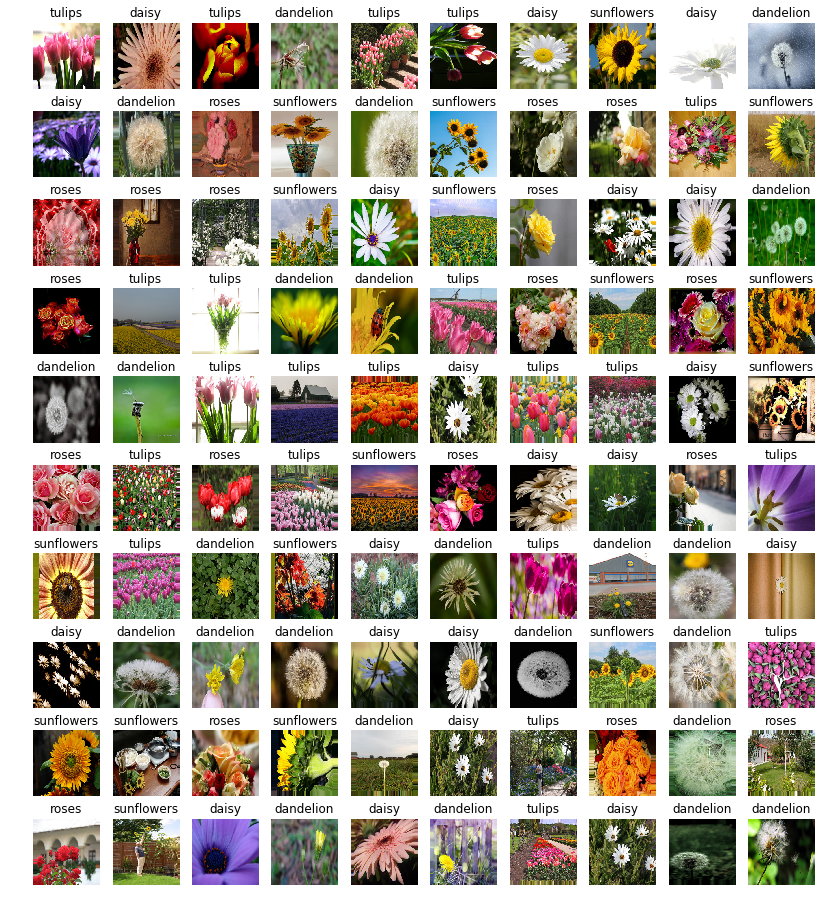

In [13]:
n_rows = 10
n_cols = 10
plt.figure(figsize=(n_cols*1.4, n_rows * 1.6))
for row in range(n_rows):
    X_batch, y_batch = next(valid_generator)
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow((X_batch[col] + 1)/2, cmap="binary", interpolation="nearest")
        plt.axis('off')
        y_class_name = classes[np.argmax(y_batch[col], axis=0)]
        plt.title(y_class_name)
plt.show()

### 4.2)
Now let's build the model:
* Create a new `Xception` model, but this time set `include_top=False` to get the model without the top layer. **Tip**: you will need to access its `input` and `output` properties.
* Make all its layers non-trainable.
* Using the functional API, add a `GlobalAveragePooling2D` layer (feeding it the Xception model's output), and add a `Dense` layer with 5 neurons and the Softmax activation function.
* Compile the model. **Tip**: don't forget to add the `"accuracy"` metric.
* Fit your model using `fit_generator()`, passing it the training and validation iterators (and setting `steps_per_epoch` and `validation_steps` appropriately).

In [21]:
base_Xmodel = keras.applications.xception.Xception(include_top=False)

In [22]:
for layer in base_Xmodel.layers:
    layer.trainable = False

In [29]:
n_classes = len(classes)

# ???
# base_Xmodel.layers.append(keras.layers.GlobalAveragePooling2D())
# base_Xmodel.layers.append(keras.layers.Dense(n_classes, activation='softmax'))

global_avg_pool = keras.layers.GlobalAveragePooling2D()(base_Xmodel.output)
flowers_predictions = keras.layers.Dense(n_classes, activation='softmax')(global_avg_pool)

model = keras.models.Model(base_Xmodel.input, flowers_predictions)
#model = base_Xmodel

model.compile(loss="categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=["accuracy"])

In [30]:
%time history = model.fit_generator( \
                                train_generator, \
                                steps_per_epoch=3306 // 32, \
                                epochs=20, \
                                validation_data=valid_generator, \
                                validation_steps=364 // 32)

Epoch 1/20
 28/103=======>......................] - ETA: 7:52 - loss: 1.5192 - acc: 0.3739

KeyboardInterrupt: 

In [18]:
plot_learning_curves(history)

NameError: name 'history' is not defined

In [ ]:
#model.evaluate(X_test_scaled, y_test)

![Exercise solution](https://camo.githubusercontent.com/250388fde3fac9135ead9471733ee28e049f7a37/68747470733a2f2f75706c6f61642e77696b696d656469612e6f72672f77696b6970656469612f636f6d6d6f6e732f302f30362f46696c6f735f736567756e646f5f6c6f676f5f253238666c69707065642532392e6a7067)

## Exercise 4 – Solution

### 4.1)
Build a `keras.preprocessing.image.ImageDataGenerator` that will preprocess the images and do some data augmentation (the [documentation](https://keras.io/preprocessing/image/) contains useful examples):

* It should at least perform horizontal flips and keep 10% of the data for validation, but you may also make it perform a bit of rotation, rescaling, etc.
* Also make sure to apply the Xception preprocessing function (using the `preprocessing_function` argument).
* Call this generator's `flow_from_directory()` method to get an iterator that will load and preprocess the flower photos from the `flower_photos` directory, setting the target size to (299, 299) and `subset` to `"training"`.
* Call this method again with the same parameters except `subset="validation"` to get a second iterator for validation.
* Get the next batch from the validation iterator and display the first image from the batch.

In [ ]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1,
    preprocessing_function=keras.applications.xception.preprocess_input)

train_generator = datagen.flow_from_directory(
        flowers_dir,
        target_size=(299, 299),
        batch_size=32,
        subset="training")

valid_generator = datagen.flow_from_directory(
        flowers_dir,
        target_size=(299, 299),
        batch_size=32,
        subset="validation")

In [ ]:
X_batch, y_batch = next(valid_generator)
plt.imshow((X_batch[0] + 1)/2)
plt.axis("off")
plt.show()

### 4.2)
Now let's build the model:
* Create a new `Xception` model, but this time set `include_top=False` to get the model without the top layer. **Tip**: you will need to access its `input` and `output` properties.
* Make all its layers non-trainable.
* Using the functional API, add a `GlobalAveragePooling2D` layer (feeding it the Xception model's output), and add a `Dense` layer with 5 neurons and the Softmax activation function.
* Compile the model. **Tip**: don't forget to add the `"accuracy"` metric.
* Fit your model using `fit_generator()`, passing it the training and validation iterators (and setting `steps_per_epoch` and `validation_steps` appropriately).

In [19]:
n_classes = 5

base_model = keras.applications.xception.Xception(include_top=False)

for layer in base_model.layers:
    layer.trainable = False

global_pool = keras.layers.GlobalAveragePooling2D()(base_model.output)
predictions = keras.layers.Dense(n_classes, activation='softmax')(global_pool)

model = keras.models.Model(base_model.input, predictions)

model.compile(loss="categorical_crossentropy",
              optimizer="sgd", metrics=["accuracy"])

In [20]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=3306 // 32,
    epochs=50,
    validation_data=valid_generator,
    validation_steps=364 // 32)

Epoch 1/50
  3/103..............................] - ETA: 9:09 - loss: 1.6292 - acc: 0.2703 

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(history.history).plot()
plt.axis([0, 19, 0, 1])
plt.show()

![Exercise](https://c1.staticflickr.com/9/8101/8553474140_c50cf08708_b.jpg)

## Object Detection Project

The Google [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset contains pictures of digits in all shapes and colors, taken by the Google Street View cars. The goal is to classify and locate all the digits in large images.
* Train a Fully Convolutional Network on the 32x32 images.
* Use this FCN to build a digit detector in the large images.